# Introduction

Nama : golda

Dataset : `https://www.kaggle.com/datasets/tongpython/cat-and-dog`

Objective : disini saya akan mencoba untuk mengklasifikasikan apakah foto tersebut merupakan anjing atau kucing dengan menggunakan computer vision.

Hugginface : `https://huggingface.co/spaces/golda/CatDog`


# Install library, sync to kaggle, and Import Libraries

men-install library yang tidak disediakan

In [1]:
!pip install -q kaggle

## sync to kaggle

menghubungkan Google Colab dengan Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"goldalearnthings","key":"27ea1fa65678afba59e8b314e9f59829"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## import libraries

memasukkan semua library yang diperlukan selama proses `Computer Vision`

In [4]:
import os
import os.path
import glob #gunakan modul glob
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import pathlib

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import load_img, img_to_array

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Data Loading

## mounting to google drive

menghubungkan ke google drive

In [5]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## download and unzip dataset

mengunduh data dari kaggle `https://www.kaggle.com/datasets/tongpython/cat-and-dog`

In [6]:
! kaggle datasets download -d tongpython/cat-and-dog

 99% 216M/218M [00:10<00:00, 21.5MB/s]
100% 218M/218M [00:10<00:00, 20.9MB/s]


men-`decompress` data yang telah diunduh

In [7]:
! unzip -q cat-and-dog.zip

## set path

membuat alur data latihan dan data tes

In [8]:
train_path = "/content/training_set/training_set/"
test_path = "/content/test_set/test_set/"
os.listdir(train_path)

['cats', 'dogs']

## creating dataframe consist of path, filename, and label 

membuat sebuah dataframe yang berisikan lokasi, nama file dan label file tersebut.

In [9]:
train_val_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_val_data['path'].append(dirpath +'/'+ f)
        train_val_data['filename'].append(f),
        train_val_data['label'].append(f.split('.')[0])

test_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(test_path):
    for f in filenames:
        test_data['path'].append(dirpath+'/'+ f)
        test_data['filename'].append(f),
        test_data['label'].append(f.split('.')[0])

In [10]:
train_val_data_df = pd.DataFrame(train_val_data)
test_data_df = pd.DataFrame(test_data)
train_val_data_df

,path,filename,label
0,/content/training_set/training_set/cats/cat.39...,cat.3947.jpg,cat
1,/content/training_set/training_set/cats/cat.33...,cat.339.jpg,cat
2,/content/training_set/training_set/cats/cat.34...,cat.3457.jpg,cat
3,/content/training_set/training_set/cats/cat.35...,cat.3583.jpg,cat
4,/content/training_set/training_set/cats/cat.24...,cat.2408.jpg,cat
...,...,...,...
8002,/content/training_set/training_set/dogs/dog.29...,dog.2926.jpg,dog
8003,/content/training_set/training_set/dogs/dog.25...,dog.2525.jpg,dog
8004,/content/training_set/training_set/dogs/dog.15...,dog.1583.jpg,dog
8005,/content/training_set/training_set/dogs/dog.30...,dog.3071.jpg,dog


In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_path) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

## cleaning data

mengecek serta memeriksa data yang didapat dari kaggle. bila terdapat data file yang memiliki format yang tidak sama dengan lainnya maka akan saya coba hapus.

### before cleaning

In [11]:
train_val_data_df['label'].value_counts()

dog          4005
cat          4000
_DS_Store       2
Name: label, dtype: int64

In [12]:
test_data_df['label'].value_counts()

dog          1012
cat          1011
_DS_Store       2
Name: label, dtype: int64

terlihat, terdapat file dengan nama `_DS_Store` pada dataset kali ini.

### processing

In [13]:
train_val_data_df_drop = train_val_data_df.loc[train_val_data_df["label"] != '_DS_Store']
test_data_df_drop = test_data_df.loc[test_data_df["label"] != '_DS_Store']

saya akan tidak menyertakan file `_DS_Strore` untuk proses kedepannya

### after cleaning

In [14]:
train_val_data_df_drop['label'].value_counts()

dog    4005
cat    4000
Name: label, dtype: int64

In [15]:
test_data_df_drop['label'].value_counts()

dog    1012
cat    1011
Name: label, dtype: int64

terlihat data sudah bersih

# EDA

## data distribution

melihat distribusi dari data yang kita punya

In [ ]:
def check_dir(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'jumlah {label} : {num_data}')

print('train set: \n' + '='*50) 
check_dir(train_path,['cats','dogs'])

print('\ntest set: \n' + '='*50) 
check_dir(test_path,['cats','dogs'])

train set: 
jumlah cats : 4001
jumlah dogs : 4006

test set: 
jumlah cats : 1012
jumlah dogs : 1013


disini, terlihat bahwa terdapat sekitar 4000 data kucing maupun anjing pada data latihan kita. maka kita dapat simpulkan bahwa dataset yang kita miliki memiliki persebaran yang rata. jumlah dataset kucing maupun anjing berkisar 1000 data. Total dataset yang tersedia berjumlah lebih dari 10.000. 

## countplot

membuat plot kemunculan pada dataset yang kita miliki.

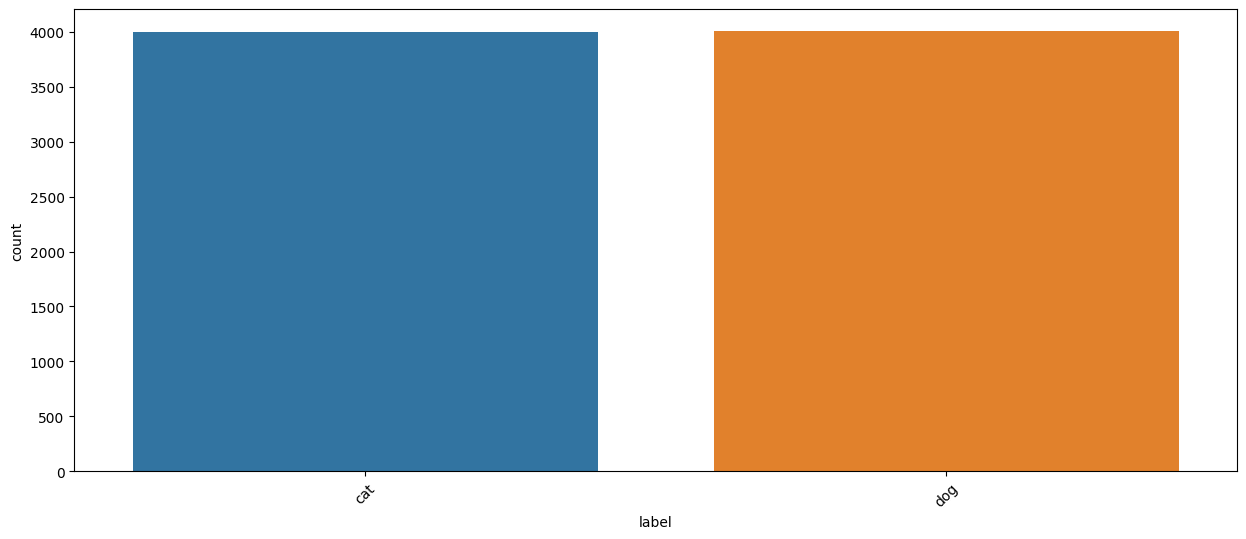

In [ ]:
plt.figure(figsize = (15,6))
#data_df['label'].value_counts().plot(kind='barh')
sns_cntplot = sns.countplot(x='label', data=train_val_data_df_drop)
plt.xticks(rotation=45);

dari `countplot` data diatas, dapat dilihat bahwa terdapat 4000 data merupakan kucing, dan 4000 data lainnya merupakan data anjing pada dataset latihan.

## shape and total pixels

disini, saya akan lebar dan panjang setiap gambar. pada gambar tersebut nantinya akan dihitung berapa banyak jumlah pixel tiap gambar.

In [ ]:
shapes_train = [] 

for _, d in train_val_data_df_drop.iterrows():
    img = load_img(d['path'])
    shapes_train.append(img.size)

In [ ]:
shapes_train = pd.DataFrame(data = shapes_train, columns = ['H', 'W'], dtype='int64')
shapes_train['Size'] = + shapes_train['H'] *shapes_train['W']
shapes_train

,H,W,Size
0,500,386,193000
1,500,374,187000
2,223,320,71360
3,499,486,242514
4,499,375,187125
...,...,...,...
8000,255,360,91800
8001,500,374,187000
8002,382,499,190618
8003,489,499,244011


#### deskripsi sederhana `shapes_train`

In [ ]:
shapes_train.describe()

,H,W,Size
count,8005.000000,8005.000000,8005.000000
mean,403.799875,360.494441,151092.737414
std,108.815185,96.935532,59918.335678
min,57.000000,41.000000,2419.000000
25%,321.000000,300.000000,103950.000000
50%,445.000000,374.000000,175000.000000
75%,499.000000,421.000000,187125.000000
max,1050.000000,768.000000,785664.000000


jadi, terlihat bahwa rata-rata gambar memiliki tinggi sebesar `403` pixel dan lebar `360`. pixel tertinggi pada gambar dalam dataset latihan sebesar `1050` dan yang terlebar sebesar `768`. dengan mengetahui panjang dan lebar pixel dalam gambar, maka kita dapat mengetahui ukuran jumlah pixel pada tiap gambar. gambar dengan jumlah pixel terendah pada angka `2419` dan yang tertinggi pada angka `785664`. 

### Images distribution

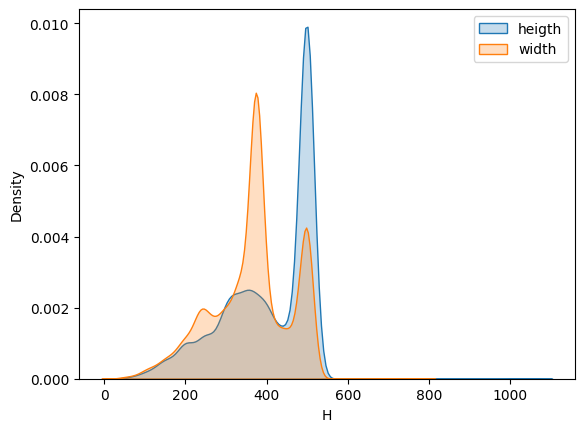

In [ ]:
# Shape of images distribution
sns.kdeplot(data=shapes_train["H"], shade=True, label='heigth')
sns.kdeplot(data=shapes_train["W"], shade=True, label='width')
plt.legend()
plt.show()

tinggi dengan persebaran foto terbanyak berada pada angka `500-550` dan untuk lebarnya berada di angka `300-350` pixel.

## sample pict

membuat fungsi pengambilan gambar random tiap kelas

In [ ]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 100)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

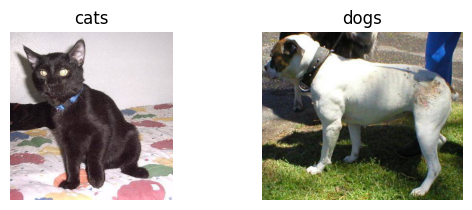

In [ ]:
# View a random image from the training dataset for all classes
for i in range(2):
    plt.subplot(2,2,i+1)
    img = view_random_image(target_dir=train_path,
                        target_class=class_names[i])

mengambil 1 foto random di tiap kelas.

# Feature Engineering

disini, saya akan melakukan `Tensorflow pipeline` yang berguna untuk memecahkan dataset latihan menjadi 2, yaitu data set latihan dan data set validasi. selain itu disini saya akan mengecilkan jumlah pixel pada tiap gambar, yaitu 220 pixel untuk tinggi maupun lebar. selain itu saya akan mengatur batch agar tidak terjadi `leaking RAM` nantinya.

## Tensorflow pipeline

In [16]:
img_height= 220
img_width= 220
batch_size= 64

In [17]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split= 0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size= batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split= 0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.
Found 2023 files belonging to 2 classes.


didapati, bahwa terdapat 2 kelas tiap data latihan, validasi dan juga data tes pada dataset yang ada
.

### train dataset examples

disini, saya ingin melihat 9 data random pada data latihan. 

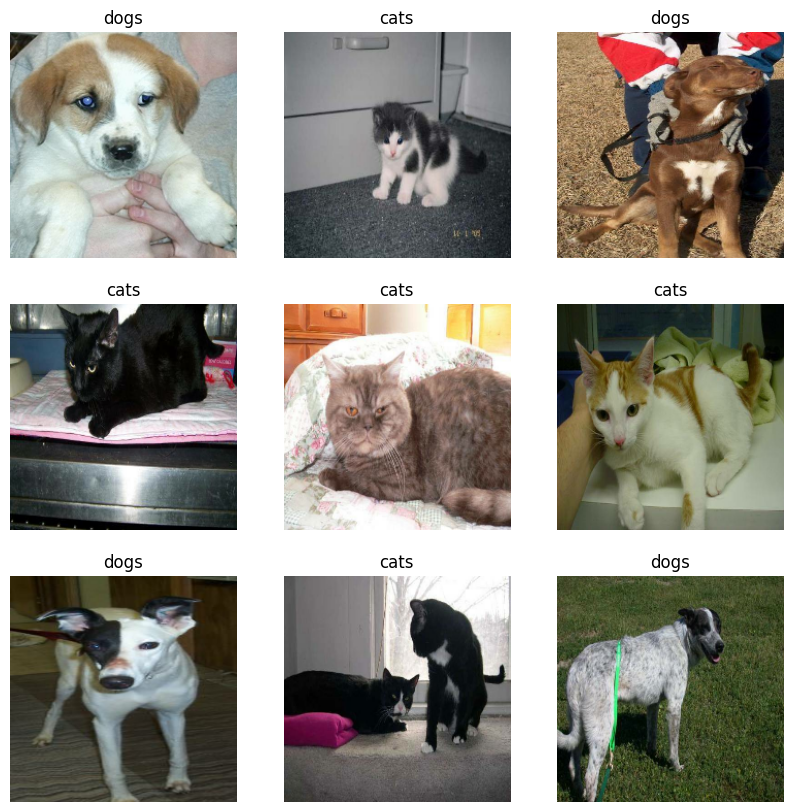

In [20]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax= plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [21]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 220, 220, 3)
(64,)


pada gambar di data latihan, terlihat bahwa terdapat `64` batch, dengan `220` tinggi dan lebarnya di masing-masing gambar. dikarenakan masing-masing gambar merupakan gambar berwarna, sehingga terdapat `3` layer. layer yang dimaksud antara lain filter warna merah, hijau dan biru.

## autotune

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

disini, saya menggunakan autotune pada parameter buffer_size. hal ini saya lakukan dikarenakan saya akan memaksimalkan tingkat buffer_size terhadap kondisi CPU/GPU/RAM yang saya gunakan saat ini.

## data augmentation

disini, saya akan membuat data augmentasi agar memperbanyak sampel yang akan dilatih.

In [23]:
inputs= (img_height, img_width,3)
data_aug= Sequential(
    [
      layers.RandomFlip('horizontal',
                          input_shape=inputs),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.1),
    ]
)

disini, foto akan saya coba ubah dengan membolak-balikkan foto, memiringkan foto sampai 20%, dan memperbesar foto sampai 10%.

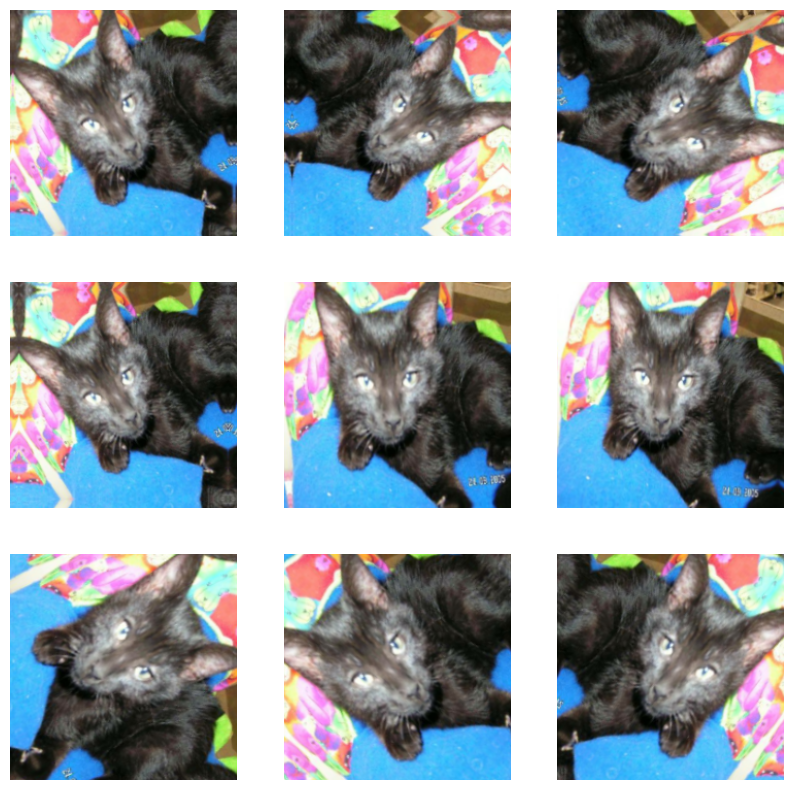

In [24]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_img= data_aug(images)
    ax=plt.subplot(3, 3, i +1)
    plt.imshow(augmented_img[0].numpy().astype('uint8'))
    plt.axis('off')

setelah dilakukan augmentasi, maka terlihat bahwa pada 9 gambar kucing yang sama memiliki posisi foto yang berbeda-beda.

# Model Definition

Convolutional Neural Network (CNN) adalah jenis arsitektur jaringan saraf tiruan yang digunakan untuk memproses data berupa gambar dan video dengan cara melakukan operasi konvolusi pada layer-layer yang berbeda. CNN berfungsi untuk menerapkan computer vision pada tiap gambar seperti klasifikasi gambar, deteksi objek, segmentasi gambar dan lainnya. CNN terdiri dari beberapa layer, termasuk layer konvolusi, pooling, aktivasi, dan fully-connected, yang masing-masing memiliki fungsi khusus dalam memproses data gambar.

# Model Training

## function plot

membuat fungsi untuk menyajikan plot dari *history* tiap kali melakukan *epochs*

In [25]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(12,6))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label = "acc")
    plt.plot(history.history['val_accuracy'], label = "val_acc")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # Plot loss function
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.legend()

    plt.show()

## Model 1

In [26]:
tf.keras.backend.clear_session()

In [27]:
# Model definition
model_1 = Sequential([
  data_aug,
  layers.Rescaling(1./255),

  # Convolutional - Pool 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),

  # Convolutional - Pool 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Convolutional - Pool 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Convolutional - Pool 4
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Flatten layer
  layers.Flatten(),

  # Fully connected layer
  layers.Dense(128, activation='relu'),

  # Output layer
  layers.Dense(units=1,activation='sigmoid')
])

# Compile model
model_1.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                    

In [28]:
epochs= 40 
history_1= model_1.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)


Epoch 1/40
101/101 [==============================] - 26s 108ms/step - loss: 0.6995 - accuracy: 0.5198 - val_loss: 0.6814 - val_accuracy: 0.5735
Epoch 2/40
101/101 [==============================] - 11s 106ms/step - loss: 0.6806 - accuracy: 0.5607 - val_loss: 0.6742 - val_accuracy: 0.6018
Epoch 3/40
101/101 [==============================] - 10s 99ms/step - loss: 0.6653 - accuracy: 0.5960 - val_loss: 0.6372 - val_accuracy: 0.6384
Epoch 4/40
101/101 [==============================] - 10s 98ms/step - loss: 0.6487 - accuracy: 0.6165 - val_loss: 0.5917 - val_accuracy: 0.6871
Epoch 5/40
101/101 [==============================] - 10s 97ms/step - loss: 0.6287 - accuracy: 0.6435 - val_loss: 0.5803 - val_accuracy: 0.6905
Epoch 6/40
101/101 [==============================] - 10s 102ms/step - loss: 0.5962 - accuracy: 0.6805 - val_loss: 0.5849 - val_accuracy: 0.6896
Epoch 7/40
101/101 [==============================] - 10s 102ms/step - loss: 0.5733 - accuracy: 0.6975 - val_loss: 0.5540 - val_accur

In [29]:
# Save into dataframe
historyBaseDF = pd.DataFrame(history_1.history)
historyBaseDF

,loss,accuracy,val_loss,val_accuracy
0,0.699459,0.519831,0.681384,0.573548
1,0.680649,0.560743,0.674201,0.601811
2,0.665287,0.596034,0.637188,0.638351
3,0.648650,0.616490,0.591725,0.687071
4,0.628702,0.643504,0.580323,0.690506
5,0.596191,0.680512,0.584931,0.689569
6,0.573275,0.697533,0.553989,0.716896
7,0.550754,0.714241,0.554764,0.714397
8,0.547233,0.715646,0.511530,0.747502
9,0.534487,0.731106,0.550971,0.727046


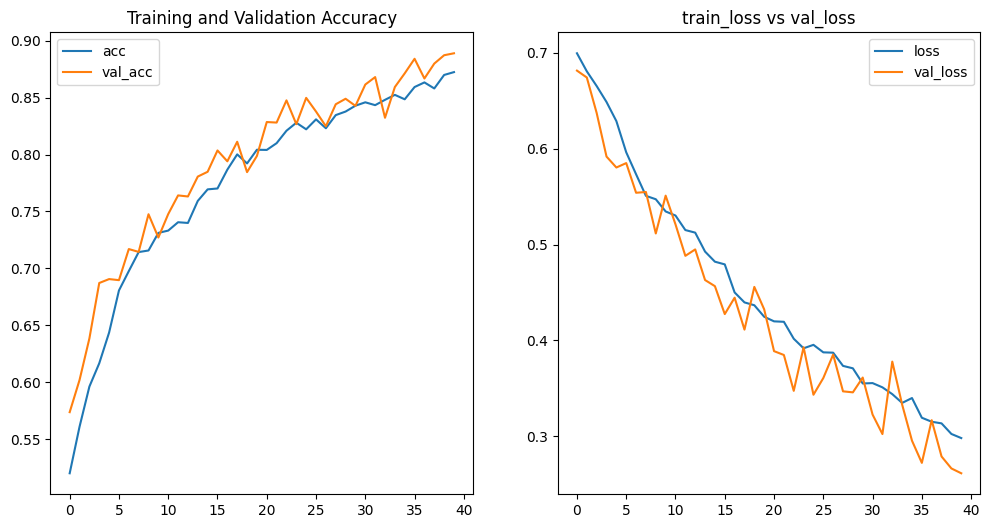

In [30]:
plot_accuracy_loss(history_1)

pada model pertama, saya melakukan `clear_session`, hal ini berguna untuk membersihkan semua `cache` yang tersimpan pada proses sebelumnya sehingga komputer tidak mengalami kebingungan pada prosesnya nanti. model yang digunakan ialah model `sequential`. pertama-tama, gambar akan dilakukan augmentasi terlebih dahulu, kemudian dilakukan penyetaraan value `1.` sampai `255`. kemudian, `layer` tersebut akan dilakukan konvolusi pertama sebanyak `16` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter `(pool_size = (2,2), padding = 'valid')` untuk mencegah model overfit, kemudian, dilanjutkan dengan konvolusi kedua sebanyak `32` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter. dilanjutkan lagi dengan konvolusi ketiga degan `64` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter. dan terakhir dilakukan konvolusi ke 4 dengan `128` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter.

data tersebut nantinya akan dibuat menjadi vektor, dan dilakukan pengerjaan *ANN* dengan hidden layer 1 di kedalaman 128 yang  aktivasi `relu`. setelah itu, data akan dimasukkan ke layer output dengan kedalaman 1 unit dan menggunakan aktivasi `sigmoid`.

model tersebut nantinya di-*compile* dengan `optimizer = adam` dan `loss=binary_crossentropy` yang digunakan untuk mencari kelas di 2 kelas saja, serta metrik pengujinya ialah `accuracy` dikarenakan data set yang digunakan sama rata(balance). model tersebut diulangi sebanyak 40 kali untuk mendapatkan hasil yang lebih baik pada setiap pengulangannya.

didapati pada model_1 memiliki tingkat akurasi dalam memprediksi gambar di dataset validasi sebesar 88,9% dan validasi loss sebesar 26,14%. 


## Model 2

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Model definition
model_2 = Sequential([
  data_aug,
  layers.Rescaling(1./255),

  # Convolutional - Pool 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), padding="same"),

  # Convolutional - Pool 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), padding="same"),

  # Convolutional - Pool 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), padding="same"),

  # Convolutional - Pool 4
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Flatten layer
  layers.Flatten(),

  # Fully connected layer
  layers.Dense(128, activation='relu'),

  # Output layer
  layers.Dense(units=1,activation='sigmoid')
])

# Compile model
model_2.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                    

In [ ]:
epochs= 40 
history_2= model_1.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)

Epoch 1/40
51/51 [==============================] - 11s 211ms/step - loss: 0.4026 - accuracy: 0.8165 - val_loss: 0.3762 - val_accuracy: 0.8264
Epoch 2/40
51/51 [==============================] - 10s 195ms/step - loss: 0.3877 - accuracy: 0.8193 - val_loss: 0.3851 - val_accuracy: 0.8248
Epoch 3/40
51/51 [==============================] - 11s 223ms/step - loss: 0.3802 - accuracy: 0.8245 - val_loss: 0.3634 - val_accuracy: 0.8398
Epoch 4/40
51/51 [==============================] - 10s 204ms/step - loss: 0.3869 - accuracy: 0.8198 - val_loss: 0.3580 - val_accuracy: 0.8409
Epoch 5/40
51/51 [==============================] - 10s 193ms/step - loss: 0.4014 - accuracy: 0.8165 - val_loss: 0.3598 - val_accuracy: 0.8378
Epoch 6/40
51/51 [==============================] - 10s 202ms/step - loss: 0.3654 - accuracy: 0.8346 - val_loss: 0.3471 - val_accuracy: 0.8443
Epoch 7/40
51/51 [==============================] - 10s 195ms/step - loss: 0.3660 - accuracy: 0.8335 - val_loss: 0.3731 - val_accuracy: 0.8331

In [ ]:
# Save into dataframe
historyDF_2 = pd.DataFrame(history_2.history)
historyDF_2

,loss,accuracy,val_loss,val_accuracy
0,0.402590,0.816521,0.376245,0.826358
1,0.387737,0.819332,0.385122,0.824797
2,0.380181,0.824485,0.363446,0.839788
3,0.386878,0.819800,0.357967,0.840881
4,0.401402,0.816521,0.359758,0.837758
5,0.365433,0.834635,0.347121,0.844316
6,0.366008,0.833542,0.373118,0.833073
7,0.370251,0.832448,0.359515,0.837601
8,0.368031,0.830262,0.401336,0.820737
9,0.375630,0.826827,0.344705,0.845565


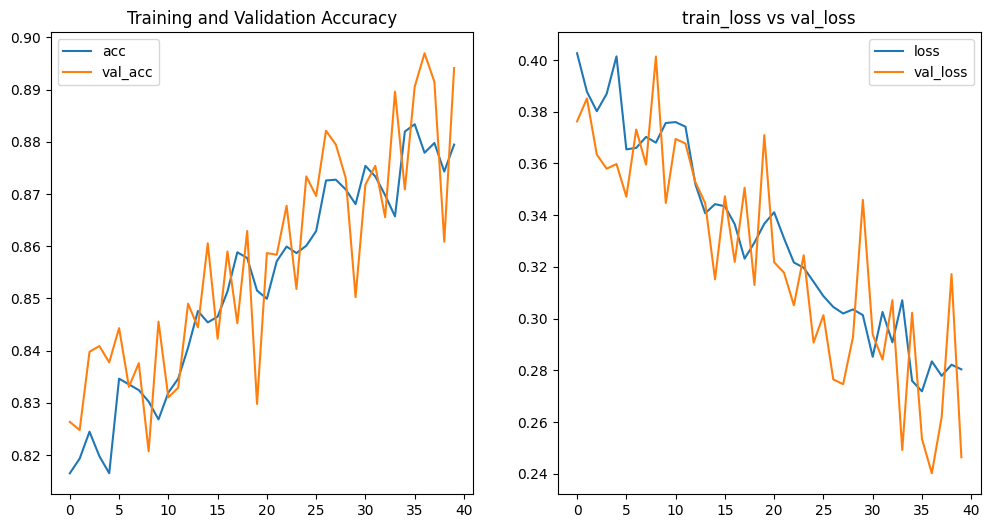

In [ ]:
plot_accuracy_loss(history_2)

pada model kedua, saya melakukan `clear_session`, hal ini berguna untuk membersihkan semua `cache` yang tersimpan pada proses sebelumnya sehingga komputer tidak mengalami kebingungan pada prosesnya nanti. model yang digunakan ialah model `sequential`. pertama-tama, gambar akan dilakukan augmentasi terlebih dahulu, kemudian dilakukan penyetaraan value `1.` sampai `255`. kemudian, `layer` tersebut akan dilakukan konvolusi pertama sebanyak `16` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan parameter `(pool_size = (3,3), padding = 'same')` untuk mencegah model overfit, kemudian, dilanjutkan dengan konvolusi kedua sebanyak `32` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan parameter `(pool_size = (3,3), padding = 'same')`. dilanjutkan lagi dengan konvolusi ketiga degan `64` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan parameter `(pool_size = (3,3), padding = 'same')`. dan terakhir dilakukan konvolusi ke 4 dengan `128` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter dan dilakukan `dropout` untuk memfilter neuron yang tidak berperan penting.

data tersebut nantinya akan dibuat menjadi vektor, dan dilakukan pengerjaan *ANN* dengan hidden layer 1 di kedalaman 128 yang  aktivasi `relu`. setelah itu, data akan dimasukkan ke layer output dengan kedalaman 1 unit dan menggunakan aktivasi `sigmoid`.

model tersebut nantinya di-*compile* dengan `optimizer = adam` dan `loss=binary_crossentropy` yang digunakan untuk mencari kelas di 2 kelas saja, serta metrik pengujinya ialah `accuracy` dikarenakan data set yang digunakan sama rata(balance). model tersebut diulangi sebanyak 40 kali untuk mendapatkan hasil yang lebih baik pada setiap pengulangannya.

didapati pada model_2 memiliki tingkat akurasi dalam memprediksi gambar di dataset validasi sebesar 89,4% dan validasi loss sebesar 24,6%. 


## Model 3

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Model definition
model_3 = Sequential([
  data_aug,
  layers.Rescaling(1./255),

  # Convolutional - Pool 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),

  # Convolutional - Pool 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), padding="same"),

  # Flatten layer
  layers.Flatten(),

  # Fully connected layer
  layers.Dense(128, activation='relu'),

  # Output layer
  layers.Dense(units=1,activation='sigmoid')
])

# Compile model
model_3.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                    

In [ ]:
epochs= 40 
history_3= model_3.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)

Epoch 1/40
51/51 [==============================] - 8s 128ms/step - loss: 0.8197 - accuracy: 0.5120 - val_loss: 0.6706 - val_accuracy: 0.5072
Epoch 2/40
51/51 [==============================] - 6s 119ms/step - loss: 0.6611 - accuracy: 0.5846 - val_loss: 0.6248 - val_accuracy: 0.6463
Epoch 3/40
51/51 [==============================] - 7s 138ms/step - loss: 0.6384 - accuracy: 0.6326 - val_loss: 0.6168 - val_accuracy: 0.6638
Epoch 4/40
51/51 [==============================] - 7s 137ms/step - loss: 0.6220 - accuracy: 0.6529 - val_loss: 0.6034 - val_accuracy: 0.6783
Epoch 5/40
51/51 [==============================] - 6s 121ms/step - loss: 0.6105 - accuracy: 0.6654 - val_loss: 0.6047 - val_accuracy: 0.6669
Epoch 6/40
51/51 [==============================] - 7s 136ms/step - loss: 0.6016 - accuracy: 0.6660 - val_loss: 0.5937 - val_accuracy: 0.6883
Epoch 7/40
51/51 [==============================] - 7s 132ms/step - loss: 0.5982 - accuracy: 0.6758 - val_loss: 0.5849 - val_accuracy: 0.6827
Epoch 

In [ ]:
# Save into dataframe
historyDF_3 = pd.DataFrame(history_3.history)
historyDF_3

,loss,accuracy,val_loss,val_accuracy
0,0.819687,0.512024,0.670560,0.507183
1,0.661095,0.584635,0.624772,0.646315
2,0.638403,0.632573,0.616754,0.663804
3,0.621980,0.652873,0.603351,0.678326
4,0.610468,0.665365,0.604656,0.666927
5,0.601560,0.665990,0.593689,0.688320
6,0.598157,0.675828,0.584860,0.682698
7,0.588104,0.678170,0.597283,0.671611
8,0.590064,0.681918,0.572318,0.704872
9,0.574249,0.693629,0.548792,0.722205


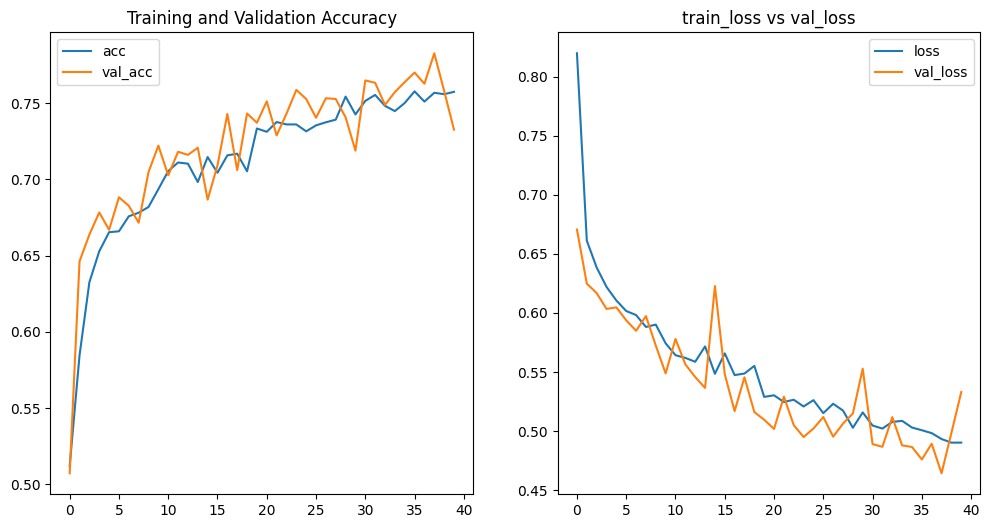

In [ ]:
plot_accuracy_loss(history_3)

pada model ketiga, saya melakukan `clear_session`, hal ini berguna untuk membersihkan semua `cache` yang tersimpan pada proses sebelumnya sehingga komputer tidak mengalami kebingungan pada prosesnya nanti. model yang digunakan ialah model `sequential`. pertama-tama, gambar akan dilakukan augmentasi terlebih dahulu, kemudian dilakukan penyetaraan value `1.` sampai `255`. kemudian, `layer` tersebut akan dilakukan konvolusi pertama sebanyak `16` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan parameter `(pool_size = (2,2), padding = 'valid')` untuk mencegah model overfit, kemudian, dilanjutkan dengan konvolusi kedua sebanyak `32` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter.

data tersebut nantinya akan dibuat menjadi vektor, dan dilakukan pengerjaan *ANN* dengan hidden layer 1 di kedalaman 128 yang  aktivasi `relu`. setelah itu, data akan dimasukkan ke layer output dengan kedalaman 1 unit dan menggunakan aktivasi `sigmoid`.

model tersebut nantinya di-*compile* dengan `optimizer = adam` dan `loss=binary_crossentropy` yang digunakan untuk mencari kelas di 2 kelas saja, serta metrik pengujinya ialah `accuracy` dikarenakan data set yang digunakan sama rata(balance). model tersebut diulangi sebanyak 40 kali untuk mendapatkan hasil yang lebih baik pada setiap pengulangannya.

didapati pada model_3 memiliki tingkat akurasi dalam memprediksi gambar di dataset validasi sebesar 73,3% dan validasi loss sebesar 53,3%. 


## Model 4

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Model definition
model_4 = Sequential([
  data_aug,
  layers.Rescaling(1./255),

  # Convolutional - Pool 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),

  # Convolutional - Pool 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), padding="same"),
  layers.Dropout(0.2),

  # Flatten layer
  layers.Flatten(),

  # Fully connected layer
  layers.Dense(64, activation='relu'),
  layers.Dense(128, activation='relu'),

  # Output layer
  layers.Dense(units=1,activation='sigmoid')
])

# Compile model
model_4.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                    

In [ ]:
epochs= 40 
history_4= model_4.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)

Epoch 1/40
51/51 [==============================] - 11s 178ms/step - loss: 0.6861 - accuracy: 0.5404 - val_loss: 0.6417 - val_accuracy: 0.6181
Epoch 2/40
51/51 [==============================] - 8s 166ms/step - loss: 0.6441 - accuracy: 0.6273 - val_loss: 0.6123 - val_accuracy: 0.6566
Epoch 3/40
51/51 [==============================] - 9s 168ms/step - loss: 0.6201 - accuracy: 0.6529 - val_loss: 0.5925 - val_accuracy: 0.6822
Epoch 4/40
51/51 [==============================] - 9s 182ms/step - loss: 0.6041 - accuracy: 0.6679 - val_loss: 0.5804 - val_accuracy: 0.6910
Epoch 5/40
51/51 [==============================] - 8s 167ms/step - loss: 0.6079 - accuracy: 0.6596 - val_loss: 0.5986 - val_accuracy: 0.6860
Epoch 6/40
51/51 [==============================] - 9s 172ms/step - loss: 0.5972 - accuracy: 0.6747 - val_loss: 0.5664 - val_accuracy: 0.7007
Epoch 7/40
51/51 [==============================] - 9s 174ms/step - loss: 0.5901 - accuracy: 0.6774 - val_loss: 0.5688 - val_accuracy: 0.7042
Epoch

In [ ]:
# Save into dataframe
historyDF_4 = pd.DataFrame(history_4.history)
historyDF_4

,loss,accuracy,val_loss,val_accuracy
0,0.686106,0.540443,0.641691,0.618051
1,0.644090,0.627264,0.612295,0.656621
2,0.620146,0.652873,0.592482,0.682230
3,0.604077,0.667864,0.580357,0.690974
4,0.607890,0.659588,0.598599,0.685978
5,0.597193,0.674735,0.566395,0.700656
6,0.590112,0.677389,0.568775,0.704247
7,0.594437,0.678638,0.553408,0.711118
8,0.574657,0.693941,0.541472,0.723923
9,0.572504,0.695659,0.544460,0.720956


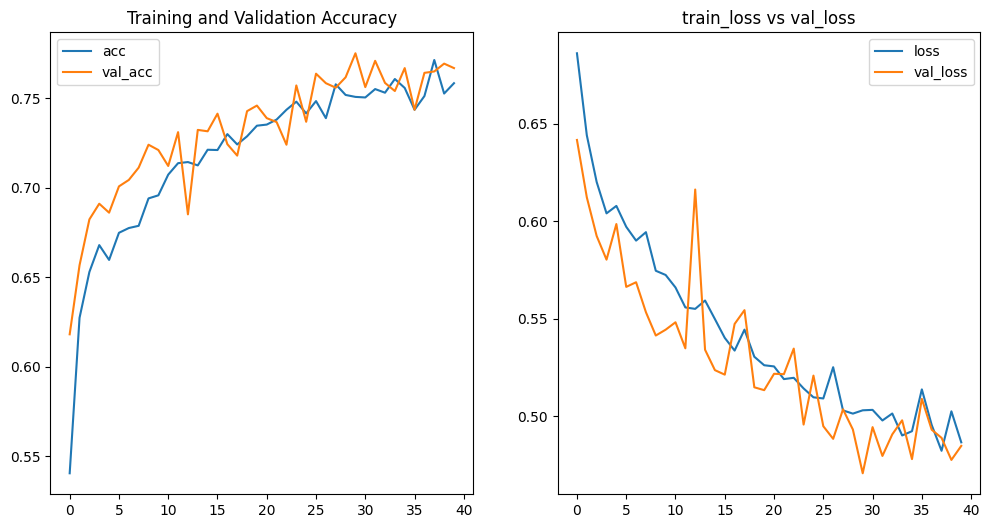

In [ ]:
plot_accuracy_loss(history_4)

pada model keempat, saya melakukan `clear_session`, hal ini berguna untuk membersihkan semua `cache` yang tersimpan pada proses sebelumnya sehingga komputer tidak mengalami kebingungan pada prosesnya nanti. model yang digunakan ialah model `sequential`. pertama-tama, gambar akan dilakukan augmentasi terlebih dahulu, kemudian dilakukan penyetaraan value `1.` sampai `255`. kemudian, `layer` tersebut akan dilakukan konvolusi pertama sebanyak `16` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan parameter `(pool_size = (2,2), padding = 'valid')` untuk mencegah model overfit, kemudian, dilanjutkan dengan konvolusi kedua sebanyak `32` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter dan dilakukan `dropout` untuk memfilter neuron yang tidak berperan penting

data tersebut nantinya akan dibuat menjadi vektor, dan dilakukan pengerjaan *ANN* dengan hidden layer 1 di kedalaman `64` yang aktivasi `relu`. dilanjutkan dengan memasukkan ke hidden layer 2 di kedalaman `128` yang diaktivasi `relu` setelah itu, data akan dimasukkan ke layer output dengan kedalaman 1 unit dan menggunakan aktivasi `sigmoid`.

model tersebut nantinya di-*compile* dengan `optimizer = adam` dan `loss=binary_crossentropy` yang digunakan untuk mencari kelas di 2 kelas saja, serta metrik pengujinya ialah `accuracy` dikarenakan data set yang digunakan sama rata(balance). model tersebut diulangi sebanyak 40 kali untuk mendapatkan hasil yang lebih baik pada setiap pengulangannya.

didapati pada model_4 memiliki tingkat akurasi dalam memprediksi gambar di dataset validasi sebesar 76,7% dan validasi loss sebesar 48,5%. 

## Model 5

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Model definition
model_5 = Sequential([
  data_aug,
  layers.Rescaling(1./255),

  # Convolutional - Pool 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),

  # Convolutional - Pool 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Flatten layer
  layers.Flatten(),

  # Fully connected layer
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(8, activation='relu'),

  # Output layer
  layers.Dense(units=1,activation='sigmoid')
])

# Compile model
model_5.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                    

In [ ]:
epochs= 40 
history_5= model_5.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)

Epoch 1/40
51/51 [==============================] - 11s 171ms/step - loss: 0.7732 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5034
Epoch 2/40
51/51 [==============================] - 8s 166ms/step - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6928 - val_accuracy: 0.5401
Epoch 3/40
51/51 [==============================] - 9s 180ms/step - loss: 0.6925 - accuracy: 0.5203 - val_loss: 0.6920 - val_accuracy: 0.5387
Epoch 4/40
51/51 [==============================] - 8s 166ms/step - loss: 0.6845 - accuracy: 0.5621 - val_loss: 0.6609 - val_accuracy: 0.6174
Epoch 5/40
51/51 [==============================] - 8s 166ms/step - loss: 0.6596 - accuracy: 0.6046 - val_loss: 0.6155 - val_accuracy: 0.6533
Epoch 6/40
51/51 [==============================] - 8s 164ms/step - loss: 0.6225 - accuracy: 0.6483 - val_loss: 0.6070 - val_accuracy: 0.6680
Epoch 7/40
51/51 [==============================] - 8s 165ms/step - loss: 0.6373 - accuracy: 0.6323 - val_loss: 0.6177 - val_accuracy: 0.6690
Epoch

In [ ]:
# Save into dataframe
historyDF_5 = pd.DataFrame(history_5.history)
historyDF_5

,loss,accuracy,val_loss,val_accuracy
0,0.773155,0.496877,0.693134,0.503435
1,0.693114,0.503748,0.692798,0.540131
2,0.692525,0.520300,0.692025,0.538726
3,0.684522,0.562149,0.660947,0.617427
4,0.659574,0.604622,0.615517,0.653342
5,0.622504,0.648345,0.607030,0.668020
6,0.637347,0.632261,0.617688,0.668957
7,0.611080,0.666771,0.631001,0.641006
8,0.608212,0.671299,0.580827,0.687851
9,0.606317,0.665834,0.586927,0.691599


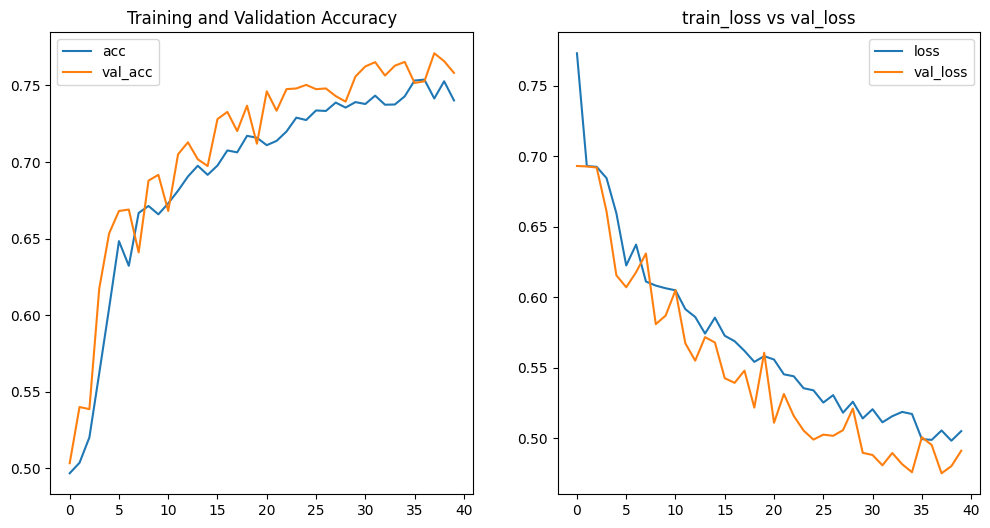

In [ ]:
plot_accuracy_loss(history_5)

pada model kelima, saya melakukan `clear_session`, hal ini berguna untuk membersihkan semua `cache` yang tersimpan pada proses sebelumnya sehingga komputer tidak mengalami kebingungan pada prosesnya nanti. model yang digunakan ialah model `sequential`. pertama-tama, gambar akan dilakukan augmentasi terlebih dahulu, kemudian dilakukan penyetaraan value `1.` sampai `255`. kemudian, `layer` tersebut akan dilakukan konvolusi pertama sebanyak `16` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan parameter `(pool_size = (2,2), padding = 'valid')` untuk mencegah model overfit, kemudian, dilanjutkan dengan konvolusi kedua sebanyak `32` filter, dengan `kernel_size = 3`, penggunaan `padding` dengan `same` dan diaktivasi oleh `relu`. kemudian, dilakukan MaxPolling2D dengan default parameter dan dilakukan `dropout` untuk memfilter neuron yang tidak berperan penting

data tersebut nantinya akan dibuat menjadi vektor, dan dilakukan pengerjaan *ANN* dengan hidden layer 1 di kedalaman `128` yang aktivasi `relu`. dilanjutkan dengan memasukkan ke hidden layer 2 di kedalaman `32` yang diaktivasi `relu`.dilanjutkan dengan memasukkan ke hidden layer 2 di kedalaman `8` yang diaktivasi `relu`. setelah itu, data akan dimasukkan ke layer output dengan kedalaman 1 unit dan menggunakan aktivasi `sigmoid`.

model tersebut nantinya di-*compile* dengan `optimizer = adam` dan `loss=binary_crossentropy` yang digunakan untuk mencari kelas di 2 kelas saja, serta metrik pengujinya ialah `accuracy` dikarenakan data set yang digunakan sama rata(balance). model tersebut diulangi sebanyak 40 kali untuk mendapatkan hasil yang lebih baik pada setiap pengulangannya.

didapati pada model_5 memiliki tingkat akurasi dalam memprediksi gambar di dataset validasi sebesar 75,8% dan validasi loss sebesar 49,1%. 

## Model 6 (With Transfer Learning)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience= 3),
    ModelCheckpoint('model_best2.hdf5', 
                    monitor='val_loss', 
                    save_best_only=True)
]

pretrained_model = tf.keras.applications.Xception(include_top=False, 
                                                  input_shape=inputs,pooling='max')
pretrained_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model_tf= Sequential()
model_tf.add(pretrained_model)

#fully connected layer
model_tf.add(Flatten())
model_tf.add(Dense(64, activation='relu')),
model_tf.add(Dense(128, activation='relu')),
model_tf.add(Dense(units=1,activation='sigmoid'))

# Compile model
model_tf.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_tf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,001,065
Trainable params: 139,585
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
epochs= 40 
history_tf= model_tf.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs
)

Epoch 1/40
51/51 [==============================] - 77s 1s/step - loss: 1.5357 - accuracy: 0.5551 - val_loss: 0.7734 - val_accuracy: 0.5612
Epoch 2/40
51/51 [==============================] - 48s 943ms/step - loss: 0.7123 - accuracy: 0.5946 - val_loss: 1.0490 - val_accuracy: 0.5643
Epoch 3/40
51/51 [==============================] - 65s 1s/step - loss: 0.7353 - accuracy: 0.5909 - val_loss: 0.6449 - val_accuracy: 0.6318
Epoch 4/40
51/51 [==============================] - 48s 941ms/step - loss: 0.6358 - accuracy: 0.6368 - val_loss: 0.5898 - val_accuracy: 0.6736
Epoch 5/40
51/51 [==============================] - 47s 925ms/step - loss: 0.6020 - accuracy: 0.6630 - val_loss: 0.5723 - val_accuracy: 0.6880
Epoch 6/40
51/51 [==============================] - 47s 932ms/step - loss: 0.5920 - accuracy: 0.6740 - val_loss: 0.5758 - val_accuracy: 0.6800
Epoch 7/40
51/51 [==============================] - 47s 932ms/step - loss: 0.5711 - accuracy: 0.6925 - val_loss: 0.5643 - val_accuracy: 0.6896
Epoch

In [ ]:
# Save into dataframe
historyDF_tf = pd.DataFrame(history_tf.history)
historyDF_tf

,loss,accuracy,val_loss,val_accuracy
0,1.535691,0.555122,0.773421,0.561212
1,0.712323,0.594628,1.048953,0.564335
2,0.735262,0.590881,0.644853,0.631793
3,0.635849,0.636790,0.589838,0.673642
4,0.602046,0.663023,0.572323,0.688007
5,0.591953,0.673954,0.575777,0.680044
6,0.571109,0.692536,0.564303,0.689569
7,0.557589,0.704872,0.527728,0.717208
8,0.545240,0.712992,0.508014,0.741880
9,0.543423,0.716427,0.651611,0.678014


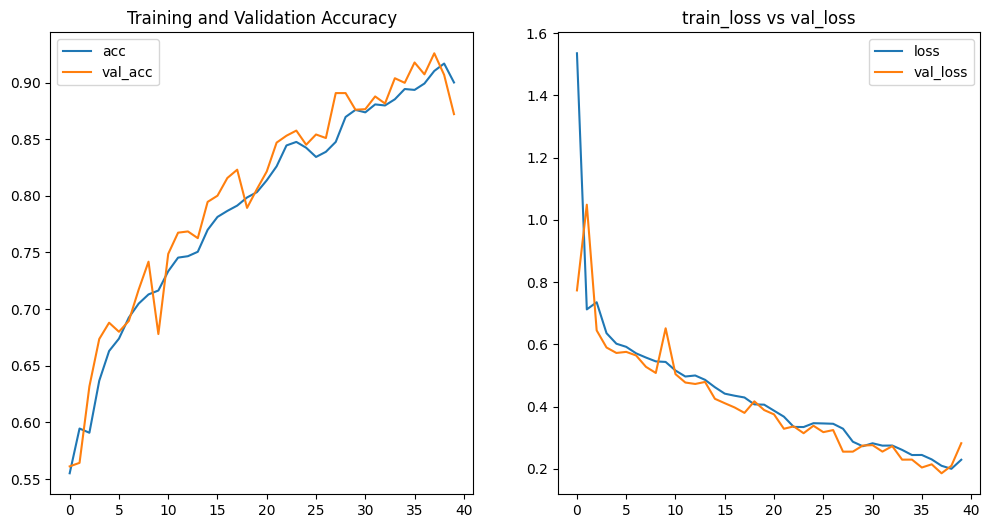

In [ ]:
plot_accuracy_loss(history_tf)

pada model 6 (transfer learning), saya melakukan *Transfer learning*. Transfer learning adalah teknik pembelajaran mesin di mana model yang sudah dilatih sebelumnya pada satu tugas digunakan sebagai awal yang baik untuk memecahkan masalah yang berbeda tapi terkait. model dimulai dengan `clear_session`, hal ini berguna untuk membersihkan semua `cache` yang tersimpan pada proses sebelumnya sehingga komputer tidak mengalami kebingungan pada prosesnya nanti. model yang digunakan ialah model `sequential`. disini, kita menggunakan *library* dari `Xception`.

data tersebut nantinya akan dibuat menjadi vektor, dan dilakukan pengerjaan *ANN* dengan hidden layer 1 di kedalaman `64` yang aktivasi `relu`. dilanjutkan dengan memasukkan ke hidden layer 2 di kedalaman `128` yang diaktivasi `relu`. setelah itu, data akan dimasukkan ke layer output dengan kedalaman 1 unit dan menggunakan aktivasi `sigmoid`.

model tersebut nantinya di-*compile* dengan `optimizer = adam` dan `loss=binary_crossentropy` yang digunakan untuk mencari kelas di 2 kelas saja, serta metrik pengujinya ialah `accuracy` dikarenakan data set yang digunakan sama rata(balance). model tersebut diulangi sebanyak 40 kali untuk mendapatkan hasil yang lebih baik pada setiap pengulangannya.

didapati pada model_6 memiliki tingkat akurasi dalam memprediksi gambar di dataset validasi sebesar 87,2% dan validasi loss sebesar 28,2%. 


# Model Evaluation

setelah semua model dilakukan pengecekan, maka didapati bahwa model ke 2 memiliki nilai akurasi validasi yang paling tinggi dan validasi loss yang paling rendah. dengan perbedaan akurasi dan validasi akurasi serta loss dan validasi loss yang tidak terlalu jauh, maka dapat disimpulkan bahwa model 2 ialah model terbaik, dan dapat diprediksi bahwa model itu dapat dikategorikan goodfit. selanjutnya dilakukan pengecekan ke dalamn data tes untuk nilai akurasinya.

In [31]:
test_results_1 = model_1.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_1[0]:.4f}')
print(f'Test Accuracy : {test_results_1[1]:.4f}')

Test Loss     : 0.3613
Test Accuracy : 0.8492


In [ ]:
test_results_2 = model_2.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_2[0]:.4f}')
print(f'Test Accuracy : {test_results_2[1]:.4f}')

Test Loss     : 0.6930
Test Accuracy : 0.5002


In [ ]:
test_results_3 = model_3.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_3[0]:.4f}')
print(f'Test Accuracy : {test_results_3[1]:.4f}')

Test Loss     : 0.5635
Test Accuracy : 0.7271


In [ ]:
test_results_4 = model_4.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_4[0]:.4f}')
print(f'Test Accuracy : {test_results_4[1]:.4f}')

Test Loss     : 0.5240
Test Accuracy : 0.7479


In [ ]:
test_results_5 = model_5.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_5[0]:.4f}')
print(f'Test Accuracy : {test_results_5[1]:.4f}')

Test Loss     : 0.5194
Test Accuracy : 0.7410


In [ ]:
test_results_tf = model_tf.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_tf[0]:.4f}')
print(f'Test Accuracy : {test_results_tf[1]:.4f}')

Test Loss     : 1.3529
Test Accuracy : 0.6293


ketika model dilakukan pengetesan pada data tes, didapati bahwa hampir kebanyakan model mengalami overfit. model terbaik pada pengetesan data tes dimiliki oleh model pertama dengan skor akurasi 84,9% dan loss 36,1%. 

Ada beberapa faktor yang dapat menyebabkan perbedaan yang signifikan pada nilai akurasi di data tes, antara lain: kurangnya variasi dalam data latih, overfitting pada model, pengambilan sampel data tes yang tidak representatif, dan perbedaan dalam pengolahan data latih dan tes. Selain itu, faktor lain seperti ketidaktepatan dalam preprocessing data, atau perbedaan dalam pengaturan model, seperti nilai hiperparameter, juga dapat menyebabkan perbedaan signifikan dalam nilai akurasi di data tes

# Model Saving

menyimpan model untuk digunakan inferencing

In [32]:
# Model conclustion
model_1.trainable = False
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 220, 220, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                    

terlihat, sudah tidak ditemukan parameter yang dapat dilatih selanjutnya. sehingga model akan tetap pada pengerjaan awalnya.

In [34]:
# Model CNN Saving
model_1.save('model_1.h5')

menyimpan model dengan format `h5`

# Kesimpulan

## Model Analysis

dari ke 6 model yang telah dilakukan, maka dapat disimpulkan bahwa model 1 merupakan model terbaik dengan nilai `accuracy: 0.8724, val_accuracy: 0.8890,loss: 0.2981, val_loss: 0.2614`. dengan pengecekan di data tes didapati hasil `Test Loss : 0.3613, Test Accuracy :0.8492` yang dapat kita simpulkan bahwa model yang kita miliki dikategorikan goodfit. pada model lainnya, didapati bahwa model sangat overfit. model overfit disebabkan salah satunya terlalu kompleks dan terlalu banyak dipelajari pada data training yang spesifik. disini saya menggunakan `data aumentation` daripada menggunakan `image generator` pada bagian `preprocessing`, hal ini disebabkan penggunaan `data augmentation` sebagai `library` untuk memperbanyak sampel berjalan lebih cepat pada proses pemodelannya. penggunaan `AUTOTUNE` dalam *prefetch* `buffer_size`-nya dimaksudkan untuk mengoptimalkan penggunaan hardware yang tersedia dalam menentukan `buffer_size` yang digunakan. pada proses `preprocessing`, saya juga melakukan perubahan ukuran gambar menjadi `220` * `220` pixel, hal ini dilakukan untuk mempercepat proses pemodelannya dan untuk penyetaraan foto yang diberikan dan selanjutnya diberikan ukuran *batch* sebesar `64` guna memotong-motong ukuran tiap batch dalam sekali jalan agar tidak terjadi overload pada RAM yang dapat menyebabkan program *crash*. kemudian pada proses pemodelannya, saya menggunakan beberapa filter pada setiap *pooling* saya berikan. Fungsi *pooling* untuk *CNN* adalah untuk mengurangi dimensi spasial dari fitur gambar, sehingga menghasilkan representasi fitur yang lebih kecil dan kompak. setelah beberapa pooling yang saya lakukan, saya lakukan *flattening* pada data tersebut. hal ini saya lakukan guna membuat data menjadi vektor sehingga dapat dikomputasi pada hidden layer selanjutnya. *hidden layer* ini sendiri berfungsi untuk memproses informasi input yang tidak bisa direpresentasikan bila langsung diproses menjadi *output*, sehingga ini akan membuat representasikan fitur yang lebih kompleks dari *machine learning* pada umumnya. setelah ditetapkan semuanya, kemudian saya men-*compile* semua data dengan loss = `binary_crossentropi` dengan metrik skoring akurasi. penggunaan `binary_crossentropy` dikarenakan target yang kita tuju merupakan pengklasifikasian biner. dikarenakan kita ingin mengetahui sebaik apa model menentukan kebenarannya apakah foto tersebut anjing atau kucing, maka kita gunakan metrik akurasi. model terbaik nantinya akan disimpan dan digunakan untuk keperluan *inferencing* foto.

## Overall Analysis

jadi, data yang kita dapat diawal ialah data foto anjing dan kucing. masing-masing berjumlah sekitar 5000 data yang telah dipisahkan data tes-nya. data yang didapat memiliki persebaran yang bagus, sehingga memungkinkan untuk dicari nilai akurasinya. dikarenakan pencarian nilai akurasi itu sangat bergantung pada kesama-rataan data, maka dalam kali ini pencarian nilai akurasi dapat dilakukan. terdapat beberapa ukuran foto dalam dataset, yaitu berkisar dari 57 pixel sampai 1050 pixel untuk tingginya dan untuk lebarnya berkisar 41 pixel sampai 768 pixel. tinggi foto dengan modus tertinggi berkisar pada angka 500 - 550 pixel dan untuk lebar foto dengan modus tertinggi berkisar pada angka 300 - 350 pixel. dengan mengetahui tinggi dan lebar pixel, maka dapat diketahui bahwa jumlah pixel yang ada berkisar 2419 sampai 785664 pixel. dengan dilakukannya *preprocessing* sampai terciptanya model, didapatkan model yang mampu mengklasifikasi gambar apakah itu gambar anjing maupun itu gambar kucing dengan tingkat akurasi mencapai 85%. saran untuk proses perbaikan kedepannya ialah, dengan mengeksplor model lebih jauh sehingga didapatkan kombinasi yang paling baik. selain itu, model dengan *transfer learning* dapat diimprove kembali dengan melakukan `epochs` lebih banyak, hal ini dikarenakan modelnya masih meningkat pada setiap `epoch`-nya.